(content:references:images_part3)=
# Images Part 3: *Self-Supervised Learning*

***Author: Marc Hon***

[](content:references:images_part2) introduced the use of image augmentations to regularize the training of a convolutional neural network. The key idea is that augmentations create "new" images subject to transformations (like a change in orientation) that prevent the network from memorizing pixels and subsequently overfitting. Because these "new" images are copies of the same object from the original, they are treated as if they belong to the same class. This property becomes very useful for **contrastive learning** in an unsupervised setting.


## Contrastive Learning

The goal of contrastive learning is to learn a representation space in which examples that are similar to one another are mapped close to one another, whereas dissimilar examples are mapped to be distant. This is typically done through the comparison (or contrast) between pairs of examples using specific network architectures, the simplest of which are **Siamese networks**.

```{figure} images/siamese.jpg
---
height: 100px
width: 350px
name: siamese
---
Schematic of a Siamese network. Image credit: [Optimum-Path Forest, Gustavo H. de Rosa, João Paulo Papa, 2022.](https://doi.org/10.1016/B978-0-12-822688-9.00015-3)
```
The key features of a Siamese network and other architectures that perform contrastive learning are that they:

- Use a **contrastive loss**, such as distance metrics (e.g., Euclidean, cosine similarity), divergence losses (InfoNCE, Jensen-Shannon divergence).
- Require a comparison of an example (the anchor) with other positive and negative examples. 

The latter, however, presents a major obstacle for using contrastive learning for representation learning -- it demands that we know ahead of time which pairs are positives and which are negatives. In other words, the method assumes access to labels that define these relationships. But if our goal in representation learning is to discover meaningful structure in unlabeled data, requiring labels at the outset defeats the purpose entirely by putting the cart before the horse!


## Image Self-supervised Learning

Self-supervised learning approaches solve this problem by creating new positive examples from **different views of the same example**, allowing for learned representations without human supervision. A popular framework to achieve this in computer vision is the [SimCLR](https://arxiv.org/pdf/2011.10566) framework.

```{figure} images/simclr.png
---
height: 300px
width: 650px
name: simclr
---
Schematic of the SimCLR framework of contrastive learning. Image credit: [Amit Chaudhary](https://amitness.com/posts/simclr)
```

In this framework, the tasks that are performed are as follows:

- **Data Augmentation**: An image is taken from the batch. Random transformations (such as random cropping or color jittering) are then applied to generate two different “views” of that same image. These two augmented views form a positive pair, since they come from the same original image. All the other images in the batch (including their augmented versions) are treated as negative pairs with respect to that anchor image.

- **Latent Representation**: Each pair is passed through an encoder to produce a latent representation, denoted as $h$. Both images share the same encoder (i.e., the encoder weights are tied)

- **Projection Representation**: These latent representations are then passed through an additional projection head (a small network of non-linear layers) to produce the projected vectors $z$.

- **Applying Contrast**: A contrastive loss is applied to the projected vectors. For positive pairs, the loss encourages their projections to be similar; for negative pairs, it pushes their projections apart. 


This training procedure acts as **representation pre-training**: by learning to distinguish between positive and negative pairs, the encoder builds latent features that capture general patterns in the data that may be useful for downstream tasks.

## Self-supervision of Galaxy10

In this Section, we will apply self-supervised learning to create and visualize a meaningful latent representation space for our the Galaxy10 dataset. 

In [1]:
import os, random
import scienceplots
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import h5py, pickle

from pathlib import Path
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import Normalize
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm
from sklearn import metrics
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.transforms import functional as TF
plt.style.use('science'); fs=15

data_folder_path = Path.cwd().resolve().parent.parent / 'ml_astro' / 'chapter4' / 'data'

/home/marc/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
filename = '/Galaxy10_DECals_64.h5'
with h5py.File(str(data_folder_path) + filename, 'r') as F_:
    images = np.array(F_['images'])
    labels = np.array(F_['ans'])

### Train-Test Splits

Here, we will preprocess the dataset in the same way as we did in [](content:references:images_part2).

```{note}
While the morphological class `y` is included in the `Dataset` and `DataLoader` instances, it is **not** used in any part of the self-supervised training.
```

In [3]:
#### Train-Validation-Test Split ####

random_state = 42

X = np.transpose(np.asarray(images).astype('float32'), (0,3,1,2))
y = np.asarray(labels).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split, idx_train, idx_split = train_test_split(X, y, np.arange(len(X)), test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test, idx_valid, idx_test = train_test_split(X_split, y_split, idx_split, test_size=0.666, random_state=random_state, shuffle=True)


#### Convert to Tensor Datasets ####

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
idx_train_tensor = torch.tensor(idx_train, dtype=torch.long)  
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(1)
idx_valid_tensor = torch.tensor(idx_valid, dtype=torch.long)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
idx_test_tensor = torch.tensor(idx_test, dtype=torch.long)  

### Data Augmentation 

There are two general strategies for incorporating augmented data into a dataset:

- Pre-compute augmentations and store them directly in the dataset.

- Generate augmentations on-the-fly during training.

The second approach is usually preferred because it keeps the memory footprint small and introduces greater diversity: each time the model sees a sample, a different random augmentation can be applied. In the following, a `Dataset` is created that allows us to define a custom augmentation pipeline comprising the following **image transformations**:

1. `RandomGrayscale` - randomly set the colours of the image to black and white with a probability `p`
2. `RandomHorizontalFlip` - randomly flip the image horizontally with probability `p`
3. `RandomRotation` - randomly rotate the image clockwise or counter-clockwise up to a quantity specified to `degrees`

```{admonition} Image Transforms as Augmentations
:class: tip

In [](content:references:images_part2), we only applied a simple rotation. Here, the `Dataset` adds spatial (`RandomHorizontalFlip`) and color (`RandomGrayscale`) transformations. How might these transformations help the model see *different versions* of the same image?  
```

In [4]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import random
from torchvision.transforms import InterpolationMode as IM

class Identity:
    def __call__(self, x):
        return x
    
class RandomAugmentor(Dataset):
    def __init__(self, tensors, do_aug=True, return_labels = False):
        self.X, self.y, self.idx = tensors
        self.return_labels = return_labels
        
        if do_aug:
            self.transform = T.Compose([
                T.RandomGrayscale(p=0.5),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomRotation(
                degrees=180,                 # uniform in [-180, 180]
                interpolation=IM.BILINEAR,   # smoother than nearest
                fill=0 )                     # keep background black
            ])
        else:
            # For validation/test: no augmentation
            self.transform = Identity()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, i):
        x, y = self.X[i], self.y[i].long() 
        
        if self.return_labels:
            return self.transform(x), self.transform(x), self.idx[i], y
        else:
            return self.transform(x), self.transform(x), self.idx[i]

Next, we create two `DataLoaders` for training:

`train_loader` - `DataLoader` that performs data augmentation (for training).

`train_loader_labels` - `DataLoader` that does not perform data augmentation and returns labels (for visualization).


with `val_loader_labels` and `test_loader_labels` for the validation and test sets, respectively.

In [20]:
#### Create DataLoader ####

batch_size = 256

train_ds = RandomAugmentor((X_train_tensor, y_train_tensor, idx_train_tensor),
                                  do_aug=True)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)


train_ds_labels = RandomAugmentor((X_train_tensor, y_train_tensor, idx_train_tensor),
                                  do_aug=0, return_labels=True)
train_loader_labels = DataLoader(train_ds_labels, batch_size=batch_size, shuffle=True)

val_ds_labels = RandomAugmentor((X_valid_tensor, y_valid_tensor, idx_valid_tensor),
                                  do_aug=0, return_labels=True)
val_loader_labels = DataLoader(val_ds_labels, batch_size=batch_size//2, shuffle=False)

test_ds_labels = RandomAugmentor((X_test_tensor, y_test_tensor, idx_test_tensor),
                                  do_aug=0, return_labels=True)
test_loader_labels = DataLoader(test_ds_labels, batch_size=batch_size//2, shuffle=False)

The following is a visualization of random augmentations from the custom `DataLoader`. Each row corresponds to the same image (i.e., a **positive pair**), while the columns represent difference instances of augmentation.

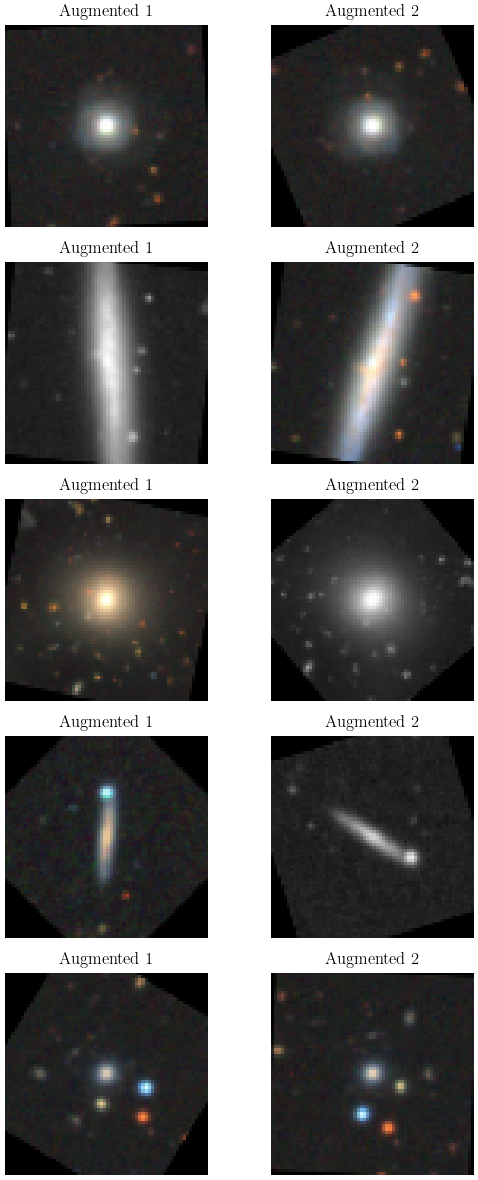

In [6]:
fig, axes = plt.subplots(5, 2, figsize=(6, 12))
for k, i in enumerate(np.random.randint(len(train_ds), size=5)):
    # Augments
    img_aug1, img_aug2, _, = train_ds[i]
    
    axes[k, 0].imshow(img_aug1.permute(1, 2, 0).cpu().numpy().astype('uint8'))
    axes[k, 0].set_title("Augmented 1")
    axes[k, 0].axis("off")
    
    axes[k, 1].imshow(img_aug2.permute(1, 2, 0).cpu().numpy().astype('uint8'))
    axes[k, 1].set_title("Augmented 2")
    axes[k, 1].axis("off")

plt.tight_layout()
plt.show()

### Contrastive learning network -- SimSiam

For this work, we will use a simplified variant of SimCLR called [SimSiam](https://arxiv.org/pdf/2011.10566). The main difference lies in its architecture and training strategy:

- SimSiam introduces a small **predictor** network after the projection head. 
- During training, gradients are propagated only through the predictor, not the projector.
- SimSiam does not require for negative examples. 

The latter requirement makes SimSiam far more efficient as it avoids the need for very large batch sizes packed with both positives and negatives. At the same time, it shows that only by pulling together different views of the same sample, useful representations can emerge.


```{figure} images/simsiam.png
---
height: 300px
width: 650px
name: simsiam
---
Schematic of SimSiam and its comparison to SimCLR. Image source: [https://arxiv.org/abs/2209.00990](https://arxiv.org/abs/2209.00990).
```

The following is an implementation of SimSiam. Note that the encoder (`backbone`) of the network is identical to the convolutional layers used in the CNN implementation in [](content:references:images_part2).

In [7]:
class SimSiam(nn.Module):
    def __init__(self, imsize):
        super().__init__()
        
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 8, 5, 1, 2), nn.BatchNorm2d(8), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8,16,3,1,1),    nn.BatchNorm2d(16), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,32,3,1,1),   nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()

        # infer flattened dim with a dummy forward
        with torch.no_grad():
            dummy = torch.zeros(1, 3, imsize, imsize)
            feat_dim = self.flatten(self.backbone(dummy)).shape[1]
        
        # projector: 3-layer MLP, BN after each, ReLU on first two, no ReLU on last
        self.projector = nn.Sequential(
            nn.Linear(feat_dim, 128), nn.BatchNorm1d(128), nn.ReLU(inplace=True),
            nn.Linear(128, 128),      nn.BatchNorm1d(128), nn.ReLU(inplace=True),
            nn.Linear(128, 128),    
        )

        # predictor: 2-layer MLP, BN+ReLU on hidden, no BN/ReLU on output
        self.predictor = nn.Sequential(
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(inplace=True),
            nn.Linear(64, 128)
        )

    def forward(self, x):
        # backbone features for probes/UMAP
        h = self.backbone(x).flatten(1)     # (B, feat_dim)
        z = self.projector(h)               # (B, 128)
        p = self.predictor(z)               # (B, 128)
        return h, z, p

                
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simsiam = SimSiam(imsize = X_train_tensor.size(2)).to(device)
summary(simsiam, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
SimSiam                                  [1, 2048]                 --
├─Sequential: 1-1                        [1, 32, 8, 8]             --
│    └─Conv2d: 2-1                       [1, 8, 64, 64]            608
│    └─BatchNorm2d: 2-2                  [1, 8, 64, 64]            16
│    └─ReLU: 2-3                         [1, 8, 64, 64]            --
│    └─MaxPool2d: 2-4                    [1, 8, 32, 32]            --
│    └─Conv2d: 2-5                       [1, 16, 32, 32]           1,168
│    └─BatchNorm2d: 2-6                  [1, 16, 32, 32]           32
│    └─ReLU: 2-7                         [1, 16, 32, 32]           --
│    └─MaxPool2d: 2-8                    [1, 16, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 32, 16, 16]           4,640
│    └─BatchNorm2d: 2-10                 [1, 32, 16, 16]           64
│    └─ReLU: 2-11                        [1, 32, 16, 16]           --
│    └─M

In SimSiam, the goal is to align the **predictor output** of one view with the **projector output** of another view of the *same image*. Let’s denote:  

- $p_1, p_2$: the outputs of the predictor network for the two augmented views.  
- $z_1, z_2$: the outputs of the projection head for the same two views.  

The loss is based on the **negative cosine similarity** between a predictor and the *other* projection:  

$$
\mathcal{L}(p_1, z_2) = - \frac{p_1}{\|p_1\|_2} \cdot \frac{z_2}{\|z_2\|_2}
$$

and symmetrically,  

$$
\mathcal{L}(p_2, z_1) = - \frac{p_2}{\|p_2\|_2} \cdot \frac{z_1}{\|z_1\|_2}.
$$

The overall loss is the average of the two directions:  

$$
\mathcal{L}_{\text{SimSiam}} = \frac{1}{2}\,\Big[\,\mathcal{L}(p_1, z_2) \;+\; \mathcal{L}(p_2, z_1)\,\Big].
$$

The implementation of the loss function is straightforward, relying on `nn.CosineSimilarity`:

In [8]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)

def negative_cosine_similarity_stopgradient(pred, proj):
    return -cos(pred, proj.detach()).mean()

```{admonition} Understanding the Loss Function
:class: note

The `.detach()` method ensures that gradients are propagated only through the predictor, not the projector. Why is this step necessary in SimSiam? 

_Hint: If gradients flowed through both branches, what kind of “shortcut” might the network find to minimize the loss without learning meaningful representations?_

```

In the following, the network is trained for a small number of epochs.

In [9]:
import torch.optim as optim

optimizer = optim.Adam(simsiam.parameters(), lr=1e-4, weight_decay=1e-5) 

epochs = 50
history = {"train_loss": []}

# Training loop
for epoch in range(epochs):
    simsiam.train()
    train_loss, train_total = 0.0, 0
    
    for batch_idx, (aug1, aug2, _) in enumerate(train_loader):
        optimizer.zero_grad()
                           
        back1, proj1, pred1 = simsiam(aug1.to(device))
        back2, proj2, pred2 = simsiam(aug2.to(device))
                                
        loss = negative_cosine_similarity_stopgradient(pred1, proj2) / 2 + negative_cosine_similarity_stopgradient(pred2, proj1) / 2
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * aug1.size(0)
        train_total += aug1.size(0)
        
    train_loss /= train_total
    history["train_loss"].append(train_loss)
                        
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} - "
              f"train_loss: {train_loss:.4f}")

Epoch 1/50 - train_loss: -0.1177
Epoch 11/50 - train_loss: -0.9717
Epoch 21/50 - train_loss: -0.9876
Epoch 31/50 - train_loss: -0.9922
Epoch 41/50 - train_loss: -0.9938


### Visualizing the learned representations

To visualize the representations, the features extracted by the convolutional layers (e.g., **backbone**) are extracted and mapped to a low-dimensional space using UMAP.

In [13]:
import umap.umap_ as umap

def get_visualization_data(dataloader):
    features = []
    labels_ = []
    ids = []
    
    for batch_idx, (aug1, _, idee, target) in enumerate(dataloader):
    
        with torch.no_grad():
            back, proj, pred = simsiam(aug1.to(device))

        features.extend(back.detach().cpu().numpy().tolist())
        labels_.extend(target.detach().cpu().numpy().tolist())
        ids.extend(idee.numpy())
        
    features = np.array(features)
    features = F.normalize(torch.from_numpy(features), dim=1).numpy()
    labels_ = np.concatenate(labels_)
    
    reducer = umap.UMAP(n_components=2, n_neighbors=15, metric="cosine")
    projections = reducer.fit_transform(np.array(features))
    
    return projections, labels_, ids

In [14]:
simsiam.eval()
projections, labels_, ids = get_visualization_data(train_loader_labels)

In [15]:
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap
from bokeh.palettes import Category10

# Your mapping
label_names = {
    0: "Disturbed\nGalaxies",
    1: "Merging\nGalaxies",
    2: "Round Smooth\nGalaxies",
    3: "In-between Round\nSmooth Galaxies",
    4: "Cigar Shaped\nSmooth Galaxies",
    5: "Barred Spiral\nGalaxies",
    6: "Unbarred Tight\nSpiral Galaxies",
    7: "Unbarred Loose\nSpiral Galaxies",
    8: "Edge-on Galaxies\nwithout Bulge",
    9: "Edge-on Galaxies\nwith Bulge"
}
output_notebook()

def interactive_projection(projection, ids, xlabel, ylabel, title, fs=12):
    # map integer labels → descriptive names
    pca_df = pd.DataFrame({
        'dim_1': projection[:, 0],
        'dim_2': projection[:, 1],
        'lbl': [label_names[l] for l in labels_],  # replace with descriptive name
        'image_url': [
            f'https://raw.githubusercontent.com/mtyhon/image_data/refs/heads/master/galaxy10_images/{str(idx).zfill(6)}.jpg'
            for idx in ids
        ],
    })

    source = ColumnDataSource(pca_df)

    # sort legend entries in numeric order 0–9 by following label_names keys
    factors = [label_names[i] for i in range(10)]
    cmap = factor_cmap('lbl', palette=Category10[10], factors=factors)

    p = figure(width=700, height=600, title=title, tools="pan,wheel_zoom,reset,save")

    r = p.circle(
        'dim_1', 'dim_2', size=5.5, source=source,
        line_color='black', line_width=0.2,
        fill_color=cmap,
        legend_field='lbl'  # legend entries come from mapped labels
    )

    hover = HoverTool(tooltips=f"""
        <div>
            <div style="font-size: {fs}px;"><strong>@lbl</strong></div>
            <div><img src="@image_url" alt="" width="100" /></div>
        </div>
    """, renderers=[r])
    p.add_tools(hover)

    # Legend formatting
    p.legend.title = "Galaxy Morphology"
    p.legend.label_text_font_size = f"{fs-3}pt"
    p.legend.label_standoff = 8
    p.legend.orientation = "vertical"
    p.legend.location = "top_left"

    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel

    show(p)

Loading BokehJS ...

In [16]:
interactive_projection(projections, ids,
                xlabel = f" Dimension 1",
                ylabel = f" Dimension 2",
                title = "")

```{admonition} Investigating Learned Representations
:class: note

Use the interactive plot to **reason about what your encoder learned**. Answer the following:

- Where do clear **clusters** form? Which classes overlap, and why might that be?
- Do you notice **gradients** (e.g., size, brightness, orientation) along any latent axis?
- Find **outliers** via hover thumbnails: are they mislabeled, low S/N, truncated, or unusual morphology?

Switch the data source to the **validation** set -- `get_visualization_data(val_loader_labels)`  

and then to the **test** set -- `get_visualization_data(test_loader_labels)`

Examine the representations in the validation and test sets. 
- Are these similar to the training set's representations? 
- Do new clusters form?

```

## Downstream Tasks 

Learning useful representations in an unsupervised manner is an approach of **pre-training** the network. Following the pre-training, the feature extraction layer (`backbone`) of the network can be used for further downstream tasks. Here, we demonstrate using it to perform classification as was done in [](content:references:images_part2).

To prevent the pre-trained layers from being updated further, the layers are **frozen**: 

In [22]:
backbone = simsiam.backbone

for p in backbone.parameters():
    p.requires_grad = False

Next, a simple linear classifier is defined with the pre-trained convolutional layer (`backbone`) as the feature extractor.

In [23]:
class LinearClassifier(nn.Module):
    def __init__(self, backbone: nn.Module, num_classes: int):
        super().__init__()
        
        self.backbone = backbone                  
        self.head = nn.Sequential(
            nn.Flatten(),     
            nn.Linear(2048, 64),
            nn.ReLU(inplace=True),
#             nn.Dropout(0.35),
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
#             nn.Dropout(0.35),
            nn.Linear(32, num_classes),
        )

    def forward(self, x):
        with torch.no_grad():                     # ensure no grads through frozen trunk
            h = self.backbone(x)                  
        h = h.flatten(1)                          
        return self.head(h)

probe = LinearClassifier(backbone, num_classes=10).to(device)
optimizer_ft = optim.Adam(probe.parameters(), lr=1e-3, weight_decay=1e-4) 
criterion = nn.CrossEntropyLoss()

In [24]:
def train_classifier(model, train_loader, valid_loader):
    nb_epoch = 50
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(nb_epoch):
        # --- Training ---
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0

        for X_batch, _, _, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer_ft.zero_grad()
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch.squeeze().long())
            loss.backward()
            optimizer_ft.step()

            train_loss += loss.item() * X_batch.size(0)

            preds = torch.argmax(y_pred, dim=1)
            train_correct += (preds == y_batch.squeeze()).sum().item()
            train_total += y_batch.size(0)

        train_loss /= train_total
        train_acc = train_correct / train_total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, _, _, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch.squeeze().long())

                val_loss += loss.item() * X_batch.size(0)
                preds = torch.argmax(y_pred, dim=1)
                val_correct += (preds == y_batch.squeeze()).sum().item()
                val_total += y_batch.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save epoch results
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{nb_epoch} - "
                  f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, "
                  f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
            
    return history

history = train_classifier(probe, train_loader_labels, val_loader_labels)

Epoch 1/50 - train_loss: 2.1370, train_acc: 0.1954, val_loss: 2.0722, val_acc: 0.2172
Epoch 11/50 - train_loss: 1.4632, train_acc: 0.4754, val_loss: 1.4386, val_acc: 0.4783
Epoch 21/50 - train_loss: 1.3170, train_acc: 0.5278, val_loss: 1.3333, val_acc: 0.5115
Epoch 31/50 - train_loss: 1.2146, train_acc: 0.5654, val_loss: 1.3241, val_acc: 0.5144
Epoch 41/50 - train_loss: 1.2018, train_acc: 0.5703, val_loss: 1.2753, val_acc: 0.5335


A comparison of the training regimes of the pre-trained model (`LinearClassifier`) with the CNN from [](content:references:images_part2) (`CNNModel`) shows that the former learns to classify much more quickly, requiring fewer epochs to achieve a loss threshold. The learned representations as a result of pre-training helps achieve this. 

In [86]:
import pickle 
hist_filename = '/cnn_history.pkl'
with open(str(data_folder_path) + hist_filename, 'rb') as f:
    cnn_hist = pickle.load(f)  
    
def compare_training_curves(history, cnn_history):
    
    cnn_ls = '-.'
    
    loss, cnn_loss = history["train_loss"], cnn_history["train_loss"]
    val_loss, val_cnn_loss = history["val_loss"], cnn_history["val_loss"]
    acc, cnn_acc = history["train_acc"], cnn_history["train_acc"]
    val_acc, cnn_val_acc = history["val_acc"], cnn_history["val_acc"]

    epochs, epochs_cnn = list(range(1, len(loss) + 1)), list(range(1, len(cnn_loss) + 1))
    epochs_min = min(epochs[-1], epochs_cnn[-1])

    figsize = (8, 4)
    fig, axis1 = plt.subplots(figsize=figsize)

    plot1_acc = axis1.plot(epochs[:epochs_min], acc[:epochs_min], 'navy', label='Pre-train\nTrain Acc.', lw=2)
    axis1.plot(epochs_cnn[:epochs_min], cnn_acc[:epochs_min], 'navy', label='No Pre-train\nTrain Acc.', ls=cnn_ls)
    
    plot1_val_acc = axis1.plot(epochs[:epochs_min], val_acc[:epochs_min], 'deepskyblue', 
                               label="Pre-train\nVal. Acc.", lw=2)
    axis1.plot(epochs_cnn[:epochs_min], cnn_val_acc[:epochs_min], 'deepskyblue', label='No Pre-train\nVal. Acc.',
               ls=cnn_ls)

    plot1_loss = axis1.plot(epochs[:epochs_min], loss[:epochs_min], 'red',
                            label='Pre-train\nTrain Loss', lw=2)
    axis1.plot(epochs_cnn[:epochs_min], cnn_loss[:epochs_min], 'red', label='No Pre-train\nTrain Loss', 
               ls=cnn_ls)

    plot1_val_loss = axis1.plot(epochs[:epochs_min], val_loss[:epochs_min], 
                                'lightsalmon', label="Pre-train\nVal. Loss", lw=2)
    axis1.plot(epochs_cnn[:epochs_min], val_cnn_loss[:epochs_min], 'lightsalmon',
               label='No Pre-train\nVal. Loss', ls=cnn_ls)

    
    
    plots = plot1_acc + plot1_val_acc + plot1_loss + plot1_val_loss
    labs = [plot.get_label() for plot in plots]
    axis1.set_xlabel('Epoch', fontsize=fs-3)
    axis1.set_ylabel('Loss/Accuracy', fontsize=fs-3)
    plt.title("Loss/Accuracy History", fontsize=fs-3)
    plt.tight_layout()
    axis1.tick_params(axis='both', labelsize=fs-3); 
    axis1.legend(bbox_to_anchor=(1.005, 1.06), frameon=True, framealpha=0.85, prop={'size':fs-3})
    plt.show()

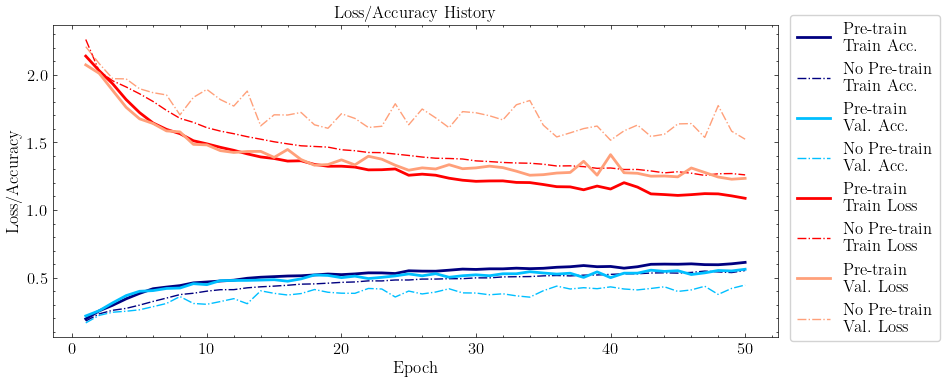

In [87]:
compare_training_curves(history, cnn_hist)

```{admonition} Exercise: Further Improvements
:class: note

1. In the interactive scatter plot, the coloured points do not form perfectly compact clusters. This happens because the features extracted by the encoder do not always align with the class labels. For example, a **Round Smooth Galaxy** may be mapped close to a **Spiral Galaxy** in embedding space if there is a bright background object nearby, or if the two galaxies happen to be of similar size.  

   **Task:** Suggest other kinds of image augmentations that could help the encoder focus more strongly on morphology-specific features (those actually used for classification), rather than on incidental details such as background objects, brightness, or scale. Which augmentations might *reduce* these distractions and encourage tighter, label-aligned clusters?  

2. The pre-trained encoder already provides rich and powerful representations. In this context, a large MLP classifier may be more complex than necessary.  

   **Task:** Replace the MLP with a simpler method such as **logistic regression** or a **random forest** and compare results. Can a simpler model achieve comparable classification accuracy? If so, what does this tell you about the quality of the learned representations?  

```